In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [3]:
rng = np.random.default_rng(43)

# Bootstrap with Unobserved Tail

Observe a sample of values but assume there are values which are unobserved (typically in the tail, but not neccessarily) that should be considered.

Bootstrap confidence intervals can be computed on the proportion of values within the sample. However, these are not intervals for the probabilities of these values, but instead the ratio of their probability to the total mass of the observed values:

In [26]:
# distribution with a tail
states = [0, 1, 2, 3, 4]
probs = [0.2, 0.2, 0.2, 0.2, 0.2]

In [27]:
# draw sample
x = rng.choice(states, 1000, p=probs)

# remove tail (unobserved)
x = x[x < 4]

In [32]:
# bootstrap

# bootstrap resamples
N = 1000

# resample size
n = len(x)

# estimates per resample
estimates = np.zeros((N, 4))
for i in range(N):

    # resample
    y = rng.choice(x, len(x))

    # estimate
    for j in range(4):
        estimates[i, j] = int((y == j).sum())

# quantiles
intervals = np.quantile(estimates, [0.025, 0.975], axis=0) / n

# display intervals
intervals

array([[0.2097561 , 0.23289634, 0.2402439 , 0.19878049],
       [0.26710366, 0.29271341, 0.30243902, 0.25490854]])

In [31]:
0.2 / (0.2 + 0.2 + 0.2 + 0.2)

0.25

The bootstrapped intervals do not contain the probability of a state $ p(x) = 0.2 $

Instead they contain the probability relative to the mass of observed states $\frac{p(x)}{\sum \limits_{y=1}^{4} p(y)} = 0.25 $

# Optimization

Include these 'relative bounds' in optimization constraints to test their performance.

## Bootstrap

Observe a sample of values $ \in \{0, \ldots, m \} $ and use the bootstrap to compute confidence intervals on the proportion of each value in the sample (as usual). These values are considered the probabilities relative to the observed mass $ p(obs) = \sum \limits_{x=0}^{m} p(x) $.

However, since some values in the sample may only be observed a handful of times it is not wise to trust their confidence intervals (too variable, often exlude true value) and they are instead replaced by $[0, 1]$ bounds. **But**, another option is to treat these values as part of the 'unobserved mass' (even though they are observed), removing them from the sample before bootstrapping, and exluding them from the observed mass sum:

- find observed truncation $ \{0, \ldots, m \} $ via occurence threshold (assume only tail truncated)
- remove values $ x > m $ from sample
- bootstrap proportions of values in truncation
- treat as intervals for $ \frac{p(x)}{\sum \limits_{y=0}^{m} p(y)} $

(drop = True)

(drop = False does not remove values outside truncation, just bootstraps as usual)

In [4]:
def bootstrap(sample, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # OB truncation bounds
    xmin, xmax = int(sample.min()), int(sample.max())
    sample_counts = np.bincount(sample, minlength=(xmax + 1))
    t_indices = np.where(sample_counts > tau)[0]
    tmin, tmax = int(t_indices.min()), int(t_indices.max())

    # if drop: remove values outside the truncation before bootstrapping
    if drop:
        sample = sample[sample >= tmin]
        sample = sample[sample <= tmax]

    # bootstrap
    intervals = np.empty((2, xmax + 1))
    intervals[0, :] = 0
    intervals[1, :] = 1

    # resample
    resamples = rng.choice(sample, size=(N, len(sample)))
    # estimate over truncation
    for x in range(tmin, tmax + 1):
        # proportion of x per resample
        estimates = (resamples == x).mean(axis=1)
        # interval
        intervals[:, x] = np.quantile(estimates, [0.025, 0.975])

    return tmin, tmax, intervals

Text(0.5, 1.0, 'Bootstrap intervals: absolute vs relative')

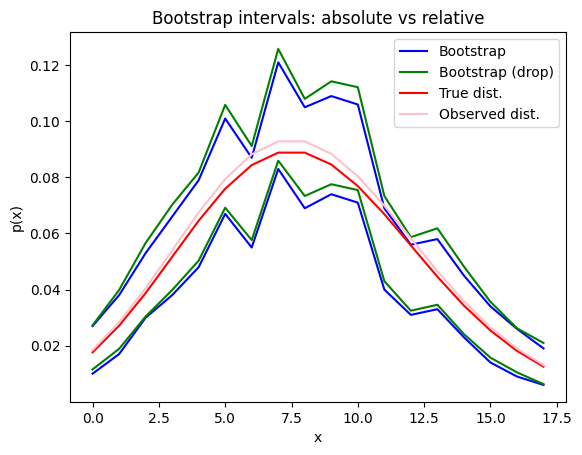

In [664]:
k = 20
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals_standard = bootstrap(sample, N, tau, drop=False)
tmin, tmax, intervals_drop = bootstrap(sample, N, tau, drop=True)
plt.plot(intervals_standard[0, tmin:tmax+1], color="blue", label="Bootstrap")
plt.plot(intervals_standard[1, tmin:tmax+1], color="blue")
plt.plot(intervals_drop[0, tmin:tmax+1], color="green", label="Bootstrap (drop)")
plt.plot(intervals_drop[1, tmin:tmax+1], color="green")

poi = scipy.stats.poisson.pmf(range(tmin, tmax + 1), k)
poi_obs = poi / sum(poi)

plt.plot(poi, color="red", label="True dist.")
plt.plot(poi_obs, color="pink", label="Observed dist.")
plt.legend()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Bootstrap intervals: absolute vs relative")

**Bootstrap** (blue) treats the probabilities computed as absolute, assuming no unobserved mass, and should bound the **true distribution (red)**

**Bootstrap (drop)** (geen) treats the probabilities computed as relative to the observed mass, and should bound the **observed distribution (pink)** where the values are probabilities relative to the observed mass (for the range of the sample) $ \frac{p(x)}{p(obs)} $

## (Standard) Absolute probabilities

Treat bootstrap intervals as bounds on probabilities

\begin{align}
    & \hat{p_{L}} \le p(x) \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \sum \limits_{x=0}^{m} p(x) \le 1 \\
    & Qp = 0
\end{align}

In [670]:
def optimize(xmax, tmin, tmax, intervals, CME=True, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            model.addConstr(p[:(tmax+1)] <= intervals[1, :(tmax+1)], name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= intervals[0, :(tmax+1)], name="prob_LB")

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x1_x2"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((xmax + 1, 2))
            for x in range(xmax + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [681]:
k = 10
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=False)
xmax = tmax
solution = optimize(xmax, tmin, tmax, intervals, CME=True)

k_tx in (9.828492165829951, 10.376965638394301), status OPTIMAL, OPTIMAL


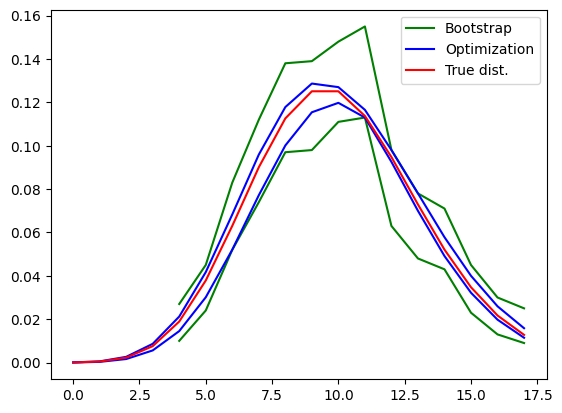

In [682]:
intervals_plot = intervals
intervals_plot[:, :tmin] = None
intervals_plot[:, (tmax+1):] = None
plt.plot(intervals_plot[0, :], color="green", label="Bootstrap")
plt.plot(intervals_plot[1, :], color="green")
plt.plot(solution['p'][:, 0], color="blue", label="Optimization")
plt.plot(solution['p'][:, 1], color="blue")
poi = scipy.stats.poisson.pmf(range(xmax + 1), k)
plt.plot(poi, color="red", label="True dist.")
plt.legend()

### Results

Produces tight bounds on parameter $k_{tx}$ and improves on boostrap bounds for probabilities as shown in graph above

## Relative probabilities

Treat bootstrap intervals as bounds on probabilities **relative to the observed mass** $ p(obs) = \sum \limits_{x=0}^{m} p(x) $

\begin{align}
    & \hat{p_{L}} \le \frac{p(x)}{p(obs)} \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \sum \limits_{x=0}^{m} p(x) \le 1 \\
    & Qp = 0
\end{align}

In [574]:
def optimize_relative(tmin, tmax, intervals, silent=True, printing=True, time_limit=300, CME=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(tmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            p_obs = p.sum()
            model.addConstr(p <= intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p >= intervals[0, :(tmax+1)] * p_obs, name="prob_LB") # lower bound * p_obs is causing the wider results

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, tmax)
                    ),
                    name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((tmax + 1, 2))
            for x in range(tmax + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [575]:
k = 2
tau = 10
N = 1000
n = 1000

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
solution = optimize_relative(tmin, tmax, intervals, CME=False)
solution_CME = optimize_relative(tmin, tmax, intervals, CME=True)

k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL
k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL


Text(0, 0.5, 'p(x)')

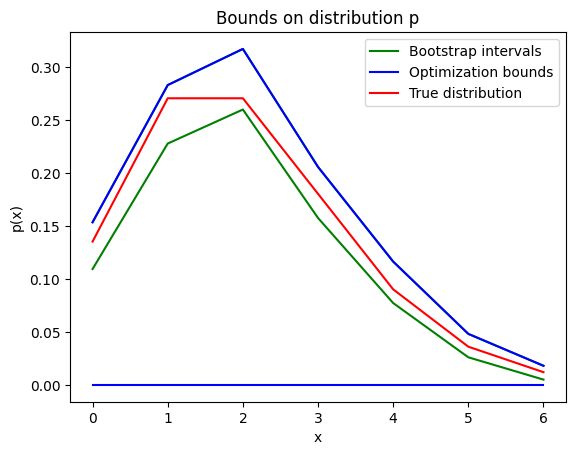

In [576]:
intervals_plot = intervals
intervals_plot[:, :tmin] = None
intervals_plot[:, (tmax+1):] = None
plt.plot(intervals_plot[0, :], color="green", label="Bootstrap intervals")
plt.plot(intervals_plot[1, :], color="green")
plt.plot(solution['p'][:, 0], color="blue", label="Optimization bounds")
plt.plot(solution['p'][:, 1], color="blue")
#plt.plot(solution['p'][:, 0], color="orange", label="Optimization bounds (CME)") # same as non-CME
#plt.plot(solution['p'][:, 1], color="orange")
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
plt.plot(poi, color="red", label="True distribution")
plt.legend()
plt.title("Bounds on distribution p")
plt.xlabel("x")
plt.ylabel("p(x)")

### Results

Poor results, no bounds enforced on the parameter and the probabilities are only bounded above by the bootstrap upper bounds with no lower bound.

The lack of lower bound on the probabilities is due to the lack of constraint on the observed mass: we know the value of the probabilities **relative** to the value of the observed mass, but there is no constraint on this value

e.g. even if a state makes up ~$\frac{3}{4}$ of the observed sample / mass, it could be that the observed mass is negligible in size compared to the unobserved mass, allowing an absolute as low as 0 (or as high as $\frac{3}{4}$)

## Including the tail

To address this issue we include the 'unobserved tail' in the optimization, taking a large value $ M >> m $ and so $ \{m + 1, \ldots, M\} $ as the tail. We do not have bootstrap intervals to bound these states, but can include in distribution and CME constraints:

\begin{align}
    & \hat{p_{L}} \le \frac{p(x)}{p(obs)} \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \sum \limits_{x=0}^{m} p(x) + \sum \limits_{x=m + 1}^{M} p(x) \le 1 \\
    & Qp = 0
\end{align}

Additionally, for a sufficiently large $M$ we can assume that the full distribution (including the unobserved tail) is represented and so can change the distribution constraint to equality:

$$ \sum \limits_{x=0}^{m} p(x) + \sum \limits_{x=m + 1}^{M} p(x) = 1 $$

(Observed mass + Un-observed mass = 1)

In [602]:
def optimize_tail(xmax, tmin, tmax, intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_eq=True, dist_opt=True, klb=None, kub=None):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # fixed parameter
            if klb:
                model.addConstr(k_tx >= klb, name="Parameter_lb")
            if kub:
                model.addConstr(k_tx <= kub, name="Parameter_ub")

            # distributional constraint
            if dist_eq:
                model.addConstr(p.sum() == 1, name="Distribution")
            else:
                model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= intervals[0, :(tmax+1)] * p_obs, name="prob_LB") # lower bound * p_obs is causing the wider results

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [750]:
def plot_distribution_results(bootstrap_intervals, solution_intervals, title):
    #sum(p) <= 1
    bootstrap_intervals[:, :tmin] = None
    bootstrap_intervals[:, (tmax+1):] = None
    poim = scipy.stats.poisson.pmf(range(tmax + 1), k)
    poiM = scipy.stats.poisson.pmf(range(tmax + 1, xmax + 1), k)
    # plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(f"Bounds on distribution: {title}")
    # bounds on observed mass
    axs[0].set_title("Observed states")
    axs[0].plot(bootstrap_intervals[0, :], color="green", label="Bootstrap intervals")
    axs[0].plot(bootstrap_intervals[1, :], color="green")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 0], color="blue", label="Optimization bounds")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 1], color="blue")
    axs[0].plot(poim, color="red", label="True distribution")
    axs[0].legend()
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("p(x)")
    # bounds on unobserved mass
    axs[1].set_title("Unobserved states")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 0], color="blue", label="Optimization bounds")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 1], color="blue")
    axs[1].plot(poiM, color="red", label="True distribution")
    axs[1].legend()
    axs[1].set_xticks(range(0, xmax - tmax, 2))
    axs[1].set_xticklabels(range(tmax + 1, xmax + 1, 2))
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("p(x)")

### Inequality vs Equality in distribution

Effect of $ \sum(p) \le 1 $ vs $ \sum(p) = 1 $

#### No CME

In [751]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
# sum(p) <= 1
solution_le = optimize_tail(xmax, tmin, tmax, intervals, CME=False, dist_eq=False)
# sum(p) == 1
solution_eq = optimize_tail(xmax, tmin, tmax, intervals, CME=False, dist_eq=True)

k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL
k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL


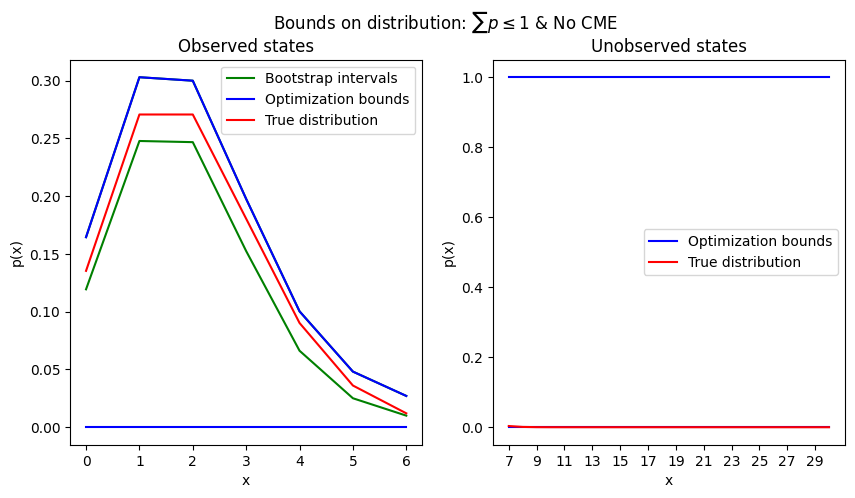

In [784]:
# sum(p) <= 1
plot_distribution_results(intervals, solution_le, r"$ \sum p \leq 1$ & No CME")

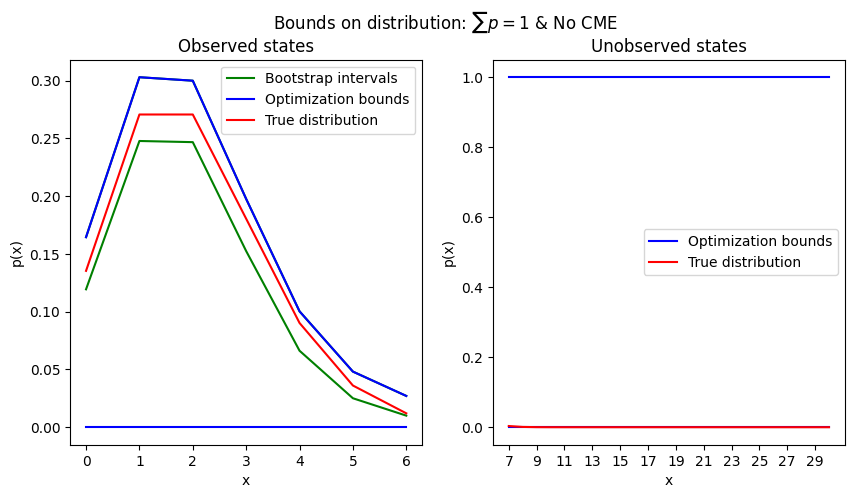

In [786]:
# sum(p) == 1
plot_distribution_results(intervals, solution_eq, r"$ \sum p = 1$ & No CME")

#### CME

In [796]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
# sum(p) <= 1
solution_le = optimize_tail(xmax, tmin, tmax, intervals, CME=True, dist_eq=False)
# sum(p) == 1
solution_eq = optimize_tail(xmax, tmin, tmax, intervals, CME=True, dist_eq=True)

k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.913888520869282, 100.0), status OPTIMAL, OPTIMAL


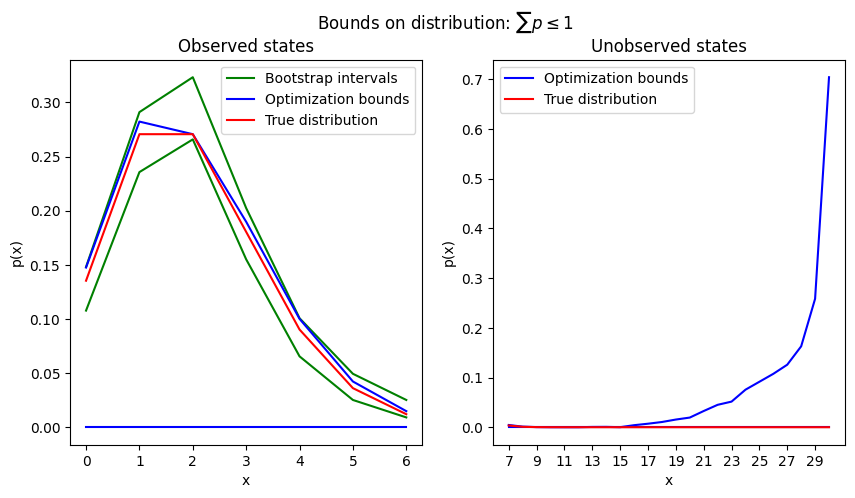

In [797]:
# sum(p) <= 1
plot_distribution_results(intervals, solution_le, r"$ \sum p \leq 1$")

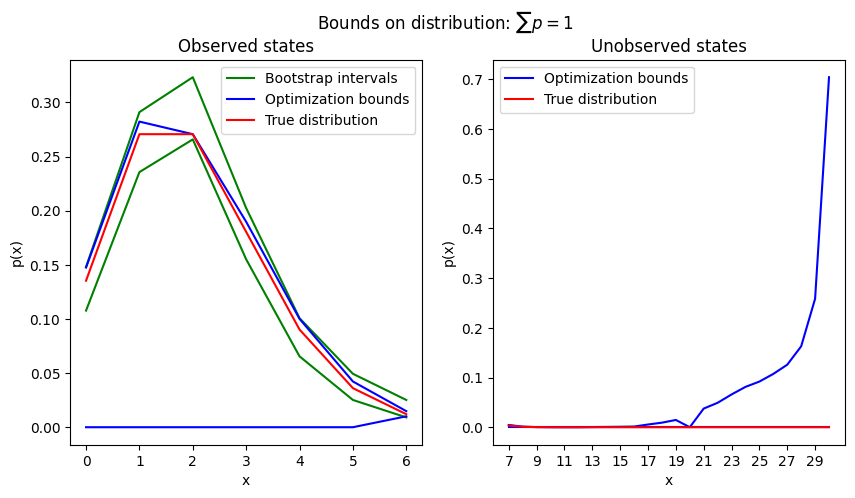

In [798]:
# sum(p) == 1
plot_distribution_results(intervals, solution_eq, r"$ \sum p = 1$")

Including the unobserved tail improves optimization bounds on observed probabilities, bringing their upper bounds down below the bootstrap. The unobserved tail probaiblities are kept tight until larger states when the bounds widen.

Using **no CME** constraints we see that these improvements dissapear, with observed bounds exactly the same as relative optimization without the tail (previous section) and no constraints (beyond $[0,1]$) on the unobserved tail. This shows the importance of the CME to combine information across the observed and unobserved states.

**Equality** in distribution constraints produces a lower bound on the parameter $k_{tx}$, and sometimes non-zero lower bounds on the observed probabilities, while **inequality** in distribution does not see these improvements.

The assumption may be hard to make rigorous, but gives some constraints on the size of observed and unobserved masses which helps greatly

### Fixing $k_{tx}$ parameter

Investigate the effect of known vs unkown model parameter in the optimization:

In [808]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

klb = None
kub = 10

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
# sum(p) <= 1
solution_le = optimize_tail(xmax, tmin, tmax, intervals, CME=True, dist_eq=False, klb=klb, kub=kub)
# sum(p) == 1
solution_eq = optimize_tail(xmax, tmin, tmax, intervals, CME=True, dist_eq=True, klb=klb, kub=kub)

k_tx in (0.0, 10.0), status OPTIMAL, OPTIMAL
k_tx in (1.9607743506456339, 2.0812424832945338), status OPTIMAL, OPTIMAL


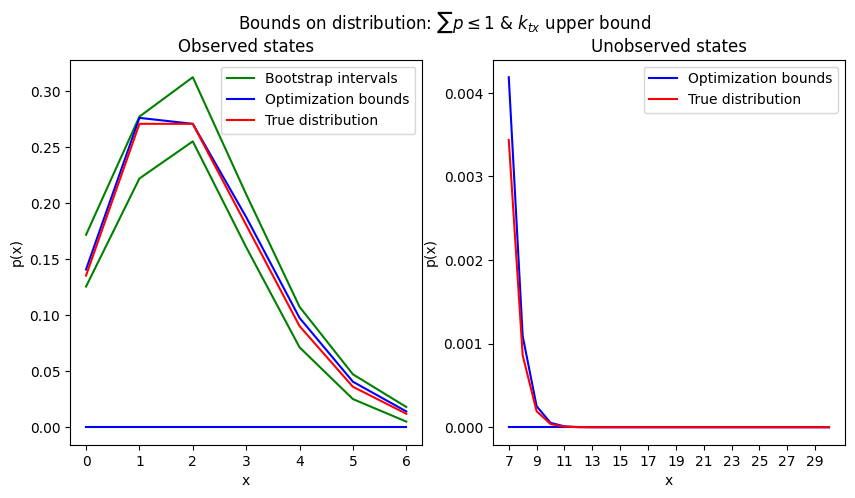

In [811]:
plot_distribution_results(intervals, solution_le, r"$ \sum p \leq 1$ & $k_{tx}$ upper bound")

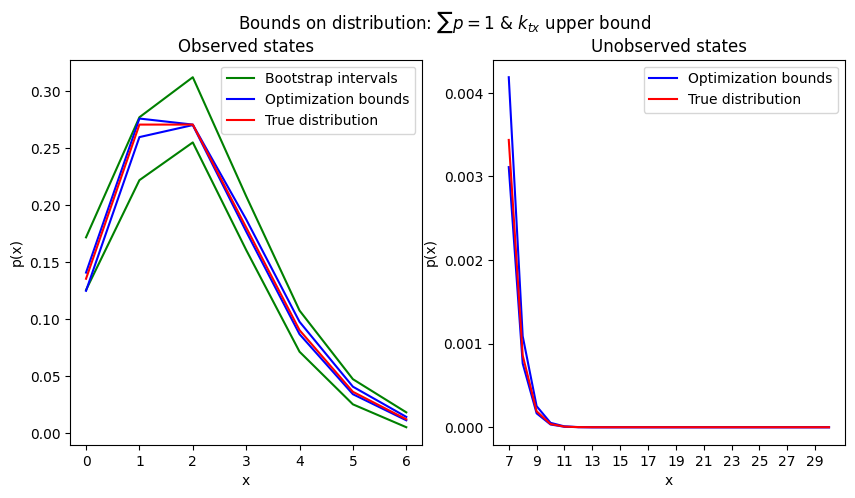

In [812]:
plot_distribution_results(intervals, solution_eq, r"$ \sum p = 1$ & $k_{tx}$ upper bound")

Even a weak upper bound, e.g. $k_{tx} \le 10$ for a true value of $2$, is enough to significantly tighten the upper bounds on both observed and unobserved probabilities (even deep into the tail).

For the **equality** in distribution this also happens for the probability lower bounds, producing results similar to the standard setting including an upper bound on the parameter (much tighter than the upper bound provided)

Overall shows the importance of the CME in constraining probabilities

### Bounding unobserved mass

Previously saw evidence that a lack of constraint on the size of observed vs unobserved mass leads to $0$ lower bounds on probabilities. This was alleviated somewhat by introducing equality in the distribution constraint, but we can go further and directly bound the size of these masses:

$$ p(obs) = \sum \limits_{x=0}^{m} p(x) \quad , \quad p(unobs) = \sum \limits_{x=m + 1}^{M} p(x) $$

Both are bounded below by $0$ and we have the constraint $ p(obs) + p(unobs) = 1 $ so can bound sizes by introducing an upper bound on the unobserved probability (as in practice this should be small):

In [5]:
def optimize_mass(xmax, tmin, tmax, intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_eq=True, dist_opt=True, klb=None, kub=None, umlb=None, umub=None):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # fixed parameter
            if klb:
                model.addConstr(k_tx >= klb, name="Parameter_lb")
            if kub:
                model.addConstr(k_tx <= kub, name="Parameter_ub")

            # distributional constraint
            if dist_eq:
                model.addConstr(p.sum() == 1, name="Distribution")
            else:
                model.addConstr(p.sum() <= 1, name="Distribution")

            # bounds on the unobserved mass
            if umub:
                model.addConstr(p[(tmax+1):] <= umub, name="Unobserved_ub")
            if umlb:
                model.addConstr(p[(tmax+1):] >= umub, name="Unobserved_lb")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= intervals[0, :(tmax+1)] * p_obs, name="prob_LB") # lower bound * p_obs is causing the wider results

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [819]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

umub = 0.1
umlb = 0

sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)
solution_bound = optimize_mass(xmax, tmin, tmax, intervals, CME=True, dist_eq=True, umub=umub, umlb=umlb)

k_tx in (1.9788927742421758, 2.1134334250813565), status OPTIMAL, OPTIMAL


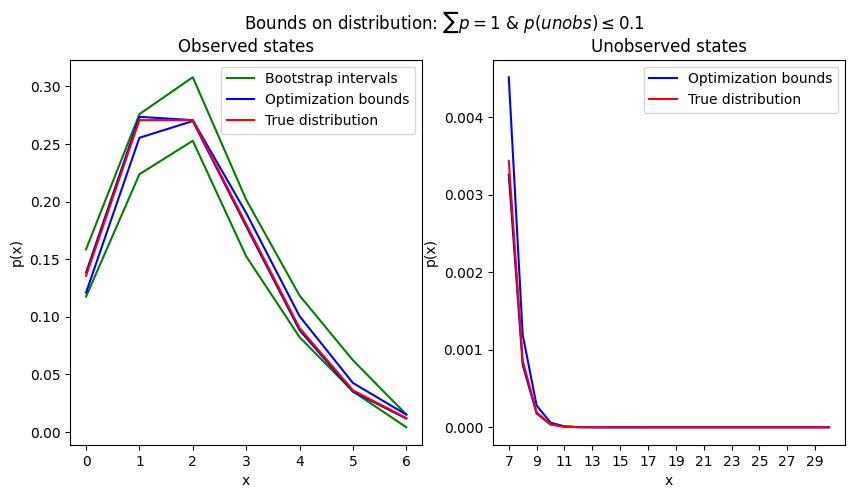

In [820]:
plot_distribution_results(intervals, solution_bound, r"$ \sum p = 1$ & $p(unobs) \leq 0.1$")

In [816]:
# true observed mass size
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
punobs = 1 - sum(poi)
print(f"True Observed mass = {punobs}")

True Observed mass = 0.004533805526248935


Even a loose upper bound of $0.1$ on the unobserved mass size (compared to true value of ~$0.004$) is enough to produce tight bounds on parameter and all probabilities (overall similar results as using upper bound on parameter in section above)

Shows that constraining the size of observed vs unobserved masses is very important to success of the method. But, this will be difficult to do rigorously.

#### Bound size effects

k_tx in (2.0534045124542493, 33.83997922205721), status OPTIMAL, OPTIMAL
k_tx in (2.053404512454457, 2.130526107265927), status OPTIMAL, OPTIMAL
k_tx in (2.053404512454504, 2.130463707154524), status OPTIMAL, OPTIMAL
k_tx in (2.053404512348373, 2.1305255907490297), status OPTIMAL, OPTIMAL


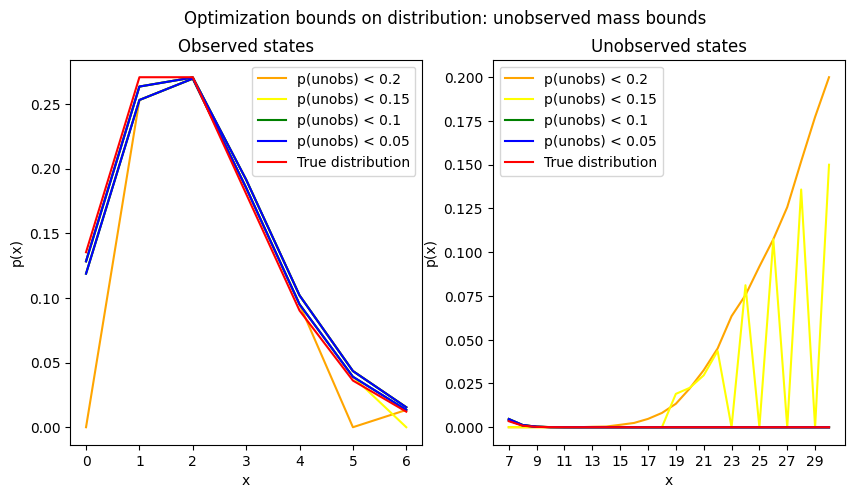

In [827]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

# upper bounds
umubs = [0.2, 0.15, 0.1, 0.05] #[0.5, 0.4, 0.3, 0.2, 0.1]
colours = ["orange", "yellow", "green", "blue", "purple"]

# simulate and bootstrap
sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f"Optimization bounds on distribution: unobserved mass bounds")

for i, umub in enumerate(umubs):

    # optimize
    solution_bound = optimize_mass(xmax, tmin, tmax, intervals, CME=True, dist_eq=True, umub=umub)

    # bounds on observed mass
    axs[0].plot(solution_bound['p'][:(tmax + 1), 0], color=colours[i], label=f"p(unobs) < {umub}")
    axs[0].plot(solution_bound['p'][:(tmax + 1), 1], color=colours[i])
    # bounds on unobserved mass
    axs[1].plot(solution_bound['p'][(tmax+1):, 0], color=colours[i], label=f"p(unobs) < {umub}")
    axs[1].plot(solution_bound['p'][(tmax+1):, 1], color=colours[i])

# plot bootstrap intervals
'''
intervals[:, :tmin] = None
intervals[:, (tmax+1):] = None
axs[0].plot(intervals[0, :], color="green", label="Bootstrap intervals")
axs[0].plot(intervals[1, :], color="green")
'''

# plot true distributions
poim = scipy.stats.poisson.pmf(range(tmax + 1), k)
poiM = scipy.stats.poisson.pmf(range(tmax + 1, xmax + 1), k)
axs[0].plot(poim, color="red", label="True distribution")
axs[1].plot(poiM, color="red", label="True distribution")

# final setup
axs[0].set_title("Observed states")
axs[0].set_xlabel("x")
axs[0].set_ylabel("p(x)")
axs[0].legend()
axs[1].set_title("Unobserved states")
axs[1].set_xticks(range(0, xmax - tmax, 2))
axs[1].set_xticklabels(range(tmax + 1, xmax + 1, 2))
axs[1].set_xlabel("x")
axs[1].set_ylabel("p(x)")
axs[1].legend()

plt.show()

# Summary

Observe states $\{0, \ldots, m\}$, bootstrap intervals $[p_{L}, p_{U}]$ on 'probabilities' and consider as probabilities relative to the observed mass: $p(obs) = \sum \limits_{x=0}^{m} p(x) $.

Take $ M >> m $ and consider $\{m + 1, \ldots, M\}$ as the 'unobserved tail'

Constraints:

$$ p_{L} \le \frac{p(x)}{p(obs)} \le p_{U} \quad , \quad x \in \{0, \ldots, m\} $$
$$ p(obs) = \sum \limits_{x=0}^{m} p(x) \quad , \quad p(unobs) = \sum \limits_{x=m + 1}^{M} p(x) $$
$$ p(obs) + p(unobs) = 1 $$
$$ Qp = 0 $$

# Work in progress

### Comparison to true size of unobserved mass

In [21]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

# simulate sample
sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)

# get observed mass
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
punobs = 1 - sum(poi)
print(f"True Observed mass = {punobs}")

# un-observed mass range
umubs = np.linspace(1, punobs, 10)

# store results
bounds = np.empty((2, len(umubs)))

# optimize
for i, umub in enumerate(umubs):
    solution_bound = optimize_mass(xmax, tmin, tmax, intervals, CME=True, dist_eq=True, umub=umub, dist_opt=False, printing=False)
    bounds[0, i] = solution_bound['min']
    bounds[1, i] = solution_bound['max']

True Observed mass = 0.004533805526248935


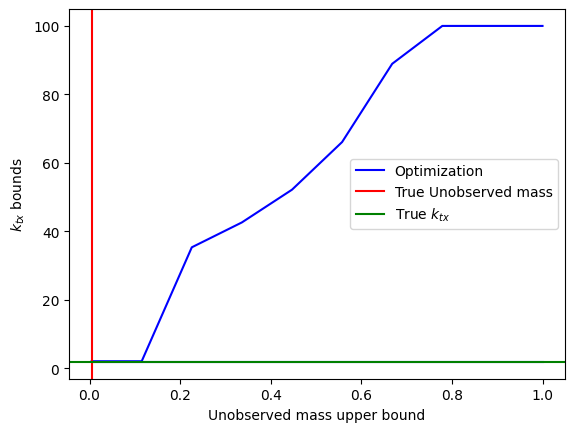

In [22]:
plt.plot(umubs, bounds[0, :], color="blue", label="Optimization")
plt.plot(umubs, bounds[1, :], color="blue")
plt.axvline(punobs, color="red", label="True Unobserved mass")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Unobserved mass upper bound")
plt.ylabel(r"$k_{tx}$ bounds")
plt.legend()

In [30]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

# simulate sample
sample = rng.poisson(k, size=n)
tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)

# get observed mass
poi = scipy.stats.poisson.pmf(range(tmax + 1), k)
punobs = 1 - sum(poi)
print(f"True Observed mass = {punobs}")

# un-observed mass range
umubs = np.linspace(0.15, punobs, 10)

# store results
bounds = np.empty((2, len(umubs)))

# optimize
for i, umub in enumerate(umubs):
    solution_bound = optimize_mass(xmax, tmin, tmax, intervals, CME=True, dist_eq=True, umub=umub, dist_opt=False, printing=False)
    bounds[0, i] = solution_bound['min']
    bounds[1, i] = solution_bound['max']

True Observed mass = 0.004533805526248935


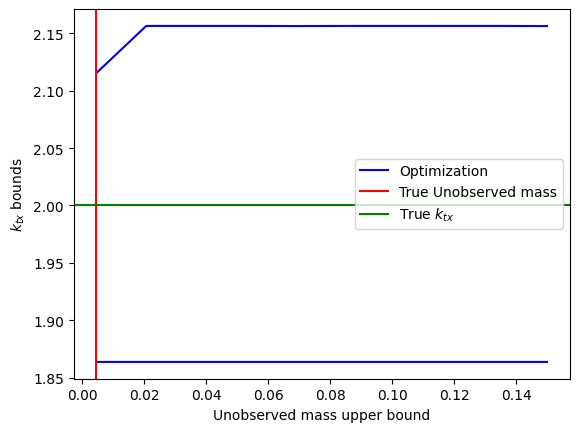

In [31]:
plt.plot(umubs, bounds[0, :], color="blue", label="Optimization")
plt.plot(umubs, bounds[1, :], color="blue")
plt.axvline(punobs, color="red", label="True Unobserved mass")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Unobserved mass upper bound")
plt.ylabel(r"$k_{tx}$ bounds")
plt.legend()

## Truncation effect

In [538]:
k = 2
#tau = 5
N = 1000
n = 1000
#xmax = 30

taus = [10]#[t for t in range(20)]
xmaxs = [x for x in range(1, 50)]
gridtest = np.zeros((len(taus), len(xmaxs)))

# simulate
sample = rng.poisson(k, size=n)

# bootstrap
for i, tau in enumerate(taus):
    tmin, tmax, intervals = bootstrap(sample, N, tau, drop=True)

    # optimize
    for j, xmax in enumerate(xmaxs):
        if xmax < tmax:
            print("Low")
            solution = {'min': None}
        else:
            solution = optimize_tail(xmax, tmin, tmax, intervals, CME=True, dist=False)
        gridtest[i, j] = solution['min']

Low
Low
Low
Low
Low
k_tx in (1.9399640878431503, 2.072801866523375), status OPTIMAL, OPTIMAL
k_tx in (1.9399640878436426, 2.0728018665243657), status OPTIMAL, OPTIMAL
k_tx in (1.9399640878440758, 2.0728018665240975), status OPTIMAL, OPTIMAL
k_tx in (1.9399640878442814, 2.07280186652403), status OPTIMAL, OPTIMAL
k_tx in (1.939964087845408, 2.07280193314819), status OPTIMAL, OPTIMAL
k_tx in (1.9399640878509334, 2.0728054732954715), status OPTIMAL, OPTIMAL
k_tx in (1.9399619150710354, 2.0728033682914444), status OPTIMAL, OPTIMAL
k_tx in (1.9399614978401294, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399645162344403, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399639196993972, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399641246945962, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399639706590601, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399639293291313, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399639146090537, 100.0), status OPTIMAL, OPTIMAL
k_tx in (1.9399639386400165, 100.0), stat

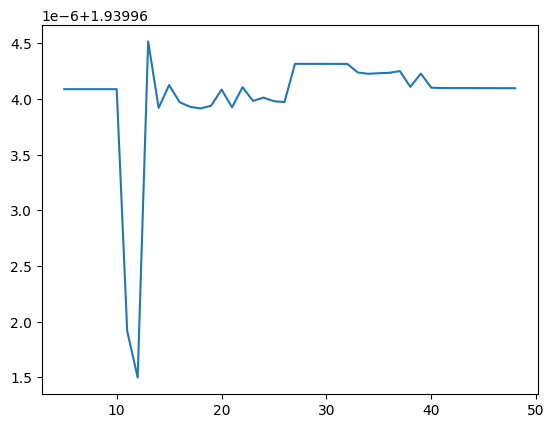

In [539]:
plt.plot(gridtest.flatten())